In [1]:
%matplotlib inline

import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [2]:
def load_scan(path):
    slices=[dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x:int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array] for s in scans)
    image = image.astype(np.int16)
    image[image == -2000] = 0
    
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != -1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
        image += np.int16(intercept)
        return np.array(image,dtype=np.int16)

In [5]:
data_path = './data/CT-Training-BE001/1.2.840.113704.1.111.2112.1167842143.1/1.2.840.113704.1.111.2112.1167842347.17/'
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [8]:
np.save('./processed data/'+"fullimages_0.npy",imgs)

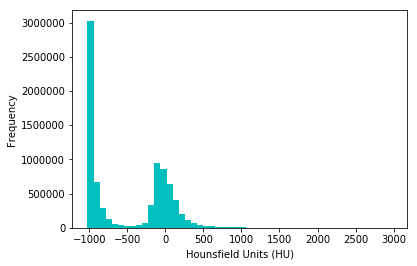

In [9]:
data = np.load("./processed data/fullimages_0.npy").astype(np.float64)
plt.hist(data.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

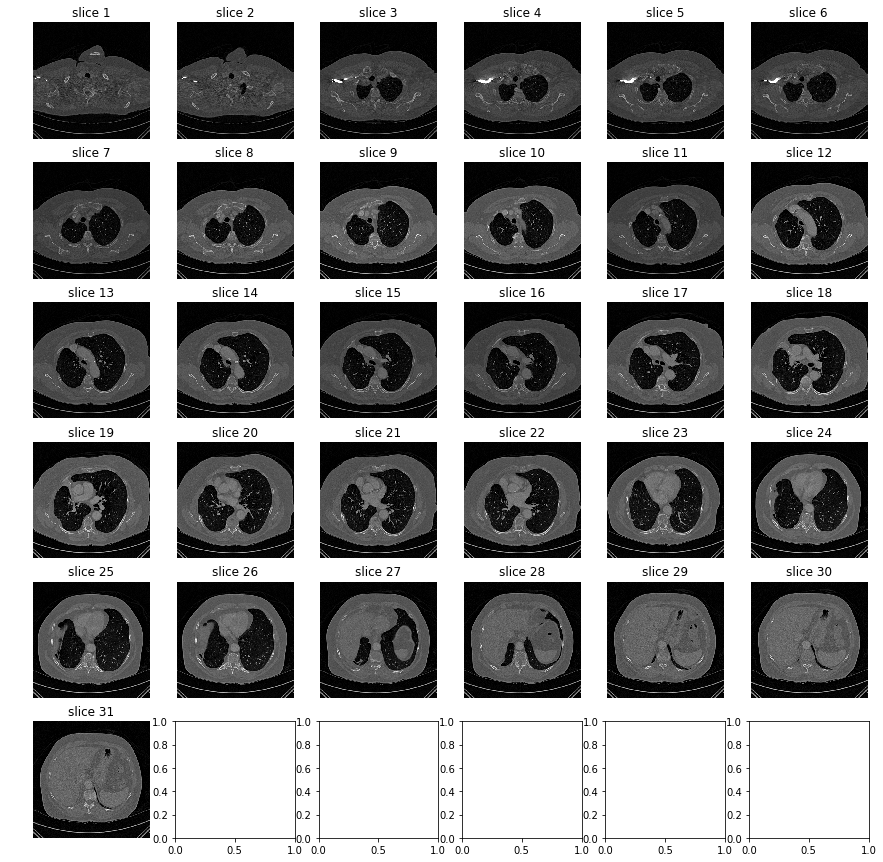

In [10]:
def sample_stack(stack, rows=6, cols=6, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[15,15])
    for i in range(rows*cols):
        index = start_with + i*show_every
        if index >= (stack.size //(512*512)):
            break
        ax[int(i/rows),int(i % rows)].set_title('slice {}'.format(index+1))
        x=stack[index].squeeze()
        ax[int(i/rows),int(i % rows)].imshow(x,cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
    
sample_stack(data,show_every=1)